# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader
import pydst
from scipy.optimize import curve_fit
import seaborn as sns
import datetime
from scipy.integrate import simps
import statsmodels.formula.api as smf
from IPython.display import display


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
#import dataproject


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [2]:
start = datetime.datetime(1990,1,1)
end = datetime.datetime(2023,3,30)
data = pandas_datareader.data.DataReader(['MICH', 'CPIAUCSL', 'UNRATE', 'NROUST'], 'fred', start, end) #Downloading The data
data['inflation_rate'] = data['CPIAUCSL'].pct_change(periods=12) * 100 # Yearly inflation rate
data['expected_inflation_lagged'] = data['MICH'].shift(12) #The expected inflation is a 12 month forward expectation.
#Creating lagged inflation:
data['lagged_inflation'] = data['inflation_rate'].shift(1)
data = data.drop('CPIAUCSL', axis = 1) # Dropping the old inflation measure
data = data.rename(columns={'UNRATE': 'unemploy_rate', 'NROUST': 'natural_rate_unemploy', 'MICH': 'expected_inflation'})
data.dropna(inplace = True) # Dropping NA values (first 12 months)
data.head(10)

,expected_inflation,unemploy_rate,natural_rate_unemploy,inflation_rate,expected_inflation_lagged,lagged_inflation
DATE,,,,,,
1991-04-01,3.2,6.7,5.637838,4.809930,3.6,4.821151
1991-07-01,3.1,6.8,5.619961,4.367816,3.4,4.695920
1991-10-01,3.2,7.0,5.602534,2.848576,4.8,3.396226
1992-01-01,2.7,7.3,5.585577,2.672606,3.9,2.980626
1992-04-01,3.0,7.4,5.569084,3.182828,3.2,3.189911
1992-07-01,2.7,7.7,5.553059,3.157122,3.1,3.014706
1992-10-01,2.8,7.3,5.537511,3.279883,3.2,2.992701
1993-01-01,2.9,7.3,5.522455,3.253796,2.7,2.966715
1993-04-01,3.0,7.1,5.507905,3.156385,3.0,3.019410


In [4]:
## Calculating the unemployment gap:
data['unemploy_gap'] = data['unemploy_rate'] - data['natural_rate_unemploy']

**Exploring The unemployment gap**

In [5]:
data['unemploy_gap'].sort_values().tail(20)

DATE
2013-04-01     2.229413
2012-04-01     2.418738
2020-10-01     2.419244
2013-01-01     2.483103
2012-01-01     2.484991
2012-07-01     2.487589
2009-01-01     2.587708
2011-10-01     2.952797
2011-07-01     3.169395
2011-04-01     3.277411
2011-01-01     3.295656
2010-10-01     3.629058
2010-07-01     3.673033
2009-04-01     3.716885
2009-07-01     4.104753
2010-01-01     4.151949
2010-04-01     4.209711
2009-10-01     4.496101
2020-07-01     5.709342
2020-04-01    10.198565
Name: unemploy_gap, dtype: float64

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [6]:
dropdown = widgets.Dropdown(options=data.columns)

# define a function that gets called when the dropdown value changes
def update_plot(column):
    plt.plot(data[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('%')
    plt.show()

# call the update_plot function when the dropdown value changes
widgets.interactive(update_plot, column=dropdown)


interactive(children=(Dropdown(description='column', options=('expected_inflation', 'unemploy_rate', 'natural_…

**Explain the interactive plot, what can be observe?**

# Analysis

**Lets compare the expectation inflation vs the actual inflation.
We will compare the lagged expectated inflation to the actual inflation to get a grasp of how good the preds were**

Text(0.5, 1.0, 'Lagged Expected vs Actual inflation')

<Figure size 2400x1600 with 0 Axes>

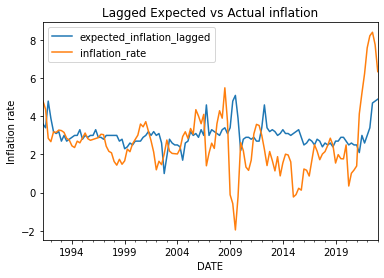

In [7]:
plt.figure(dpi = 400)
data[['expected_inflation_lagged', 'inflation_rate']].plot()
plt.ylabel('Inflation rate')
plt.title('Lagged Expected vs Actual inflation')

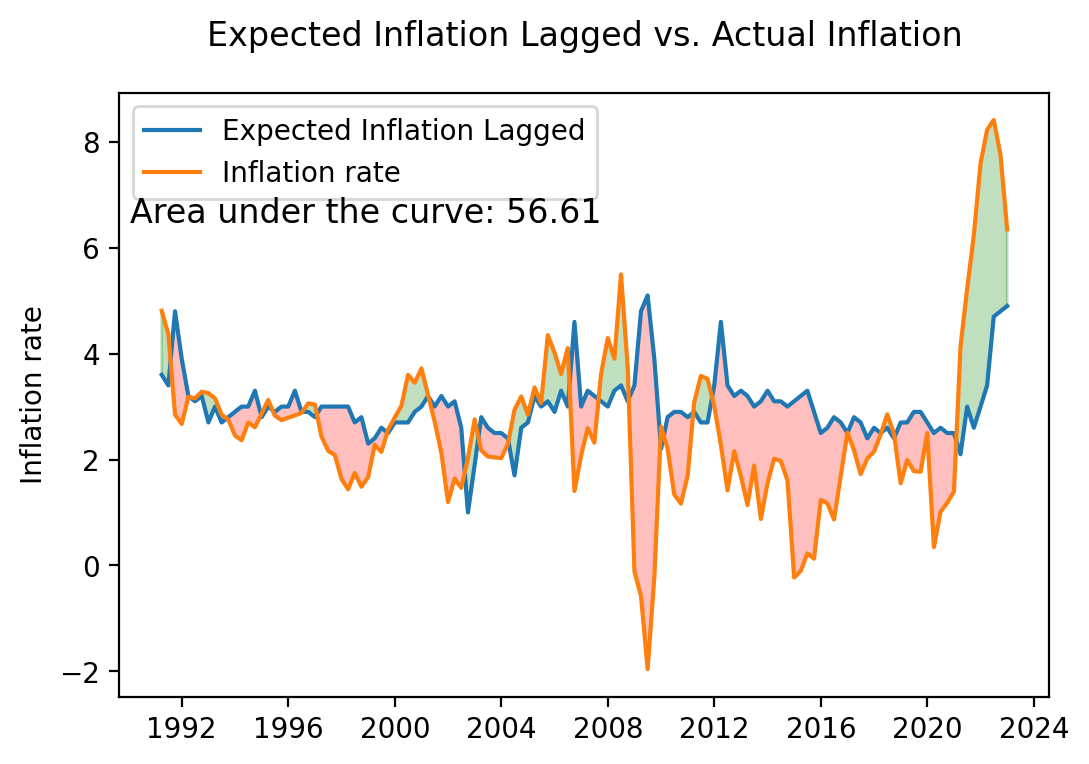

In [8]:
# Define y1 and y2 variables for expected inflation lagged and inflation rate data
y1 = data['expected_inflation_lagged']
y2 = data['inflation_rate']

# Create a new figure and set its DPI
fig = plt.figure(dpi=200)

# Plot the expected inflation lagged and inflation rate data on the figure
plt.plot(data.index, y1, label='Expected Inflation Lagged')
plt.plot(data.index, y2, label='Inflation rate')

# Fill the area between the curves with green when inflation rate is greater or equal to expected inflation lagged, and with red otherwise
plt.fill_between(data.index, y1, y2, where=y2>=y1, interpolate=True, alpha=0.25, color='green')
plt.fill_between(data.index, y1, y2, where=y2<=y1, interpolate=True, alpha=0.25, color='red')

# Calculate the area between the curves using Simpson's rule
area = abs(simps(y2 - y1))

# Set titles and labels for the plot
plt.title('Expected Inflation Lagged vs. Actual Inflation', y=1.05)
plt.suptitle('Area under the curve: {:.2f}'.format(area), x=0.33, y=0.75)
plt.ylabel('Inflation rate')
plt.legend()

# Display the plot
plt.show()

**Here we can observe that the expectated inflation is lagged, (which it also is), this tells us, that perhaps the expected inflation is not driving the changes in the actual inflation, but this is only exploring and no formal testing**

**Lets explore the expected forward looking inflation to the actual inflation**

Text(0.5, 1.0, 'Expected vs Actual inflation')

<Figure size 2400x1600 with 0 Axes>

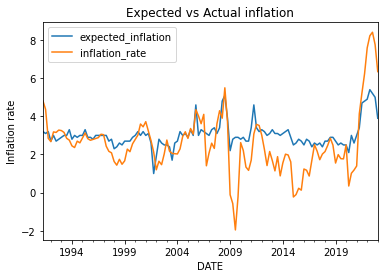

In [9]:
plt.figure(dpi = 400)
data[['expected_inflation', 'inflation_rate']].plot()
plt.ylabel('Inflation rate')
plt.title('Expected vs Actual inflation')

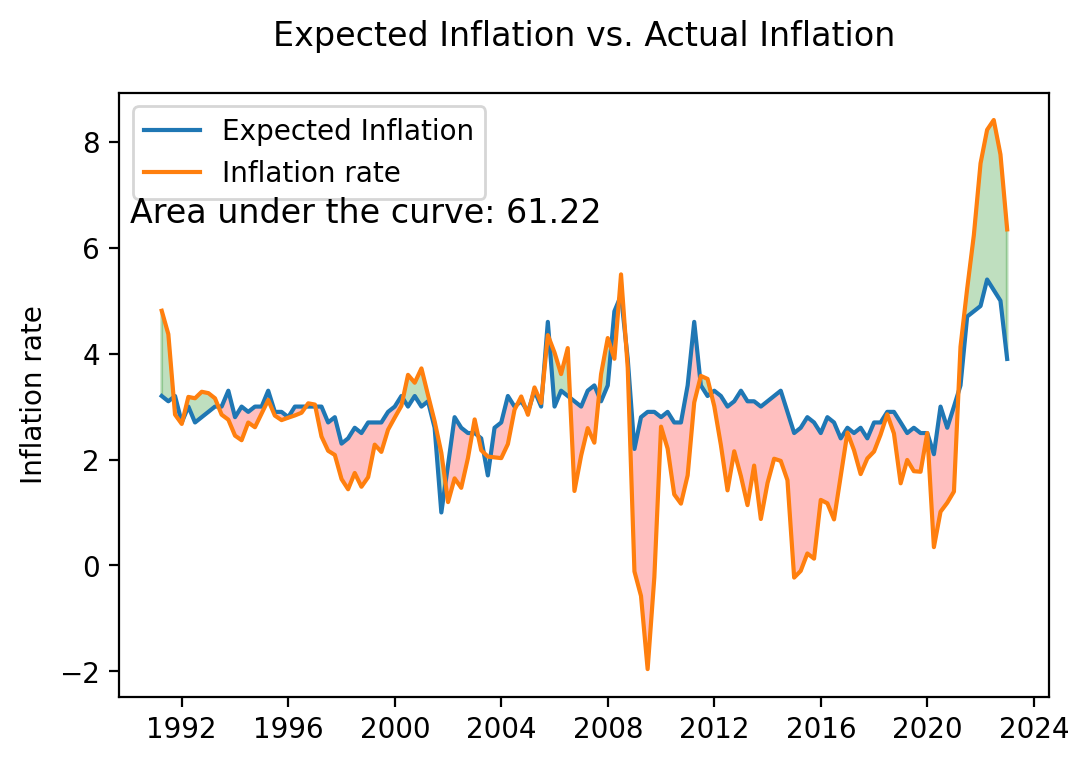

In [10]:
# Define y1 and y2 variables for Expected Inflation and inflation rate data
y1 = data['expected_inflation']
y2 = data['inflation_rate']

# Create a new figure and set its DPI
fig = plt.figure(dpi=200)

# Plot the Expected Inflation and inflation rate data on the figure
plt.plot(data.index, y1, label='Expected Inflation')
plt.plot(data.index, y2, label='Inflation rate')

# Fill the area between the curves with green when inflation rate is greater or equal to Expected Inflation, and with red otherwise
plt.fill_between(data.index, y1, y2, where=y2>=y1, interpolate=True, alpha=0.25, color='green')
plt.fill_between(data.index, y1, y2, where=y2<=y1, interpolate=True, alpha=0.25, color='red')

# Calculate the area between the curves using Simpson's rule
area = abs(simps(y2 - y1))

# Set titles and labels for the plot
plt.title('Expected Inflation vs. Actual Inflation', y=1.05)
plt.suptitle('Area under the curve: {:.2f}'.format(area), x=0.33, y=0.75)
plt.ylabel('Inflation rate')
plt.legend()

# Display the plot
plt.show()

**The absolute value for the lagged expected inflation is lower than the expected inflation**

**From this graph, we can see, that when the actual inflation rate is changing, so it the expected inflation. (Or vice versa)**

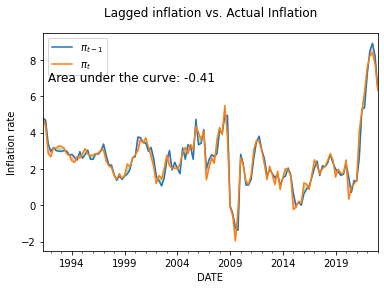

In [11]:
data['lagged_inflation'].plot(label='$\pi_{t-1}$')
data['inflation_rate'].plot(label='$\pi_t$')

# fill area between the curves
plt.fill_between(data.index, data['lagged_inflation'], data['inflation_rate'], where=data['inflation_rate']>=data['lagged_inflation'], interpolate=True, alpha=0.25, color='green')
plt.fill_between(data.index, data['lagged_inflation'], data['inflation_rate'], where=data['inflation_rate']<=data['lagged_inflation'], interpolate=True, alpha=0.25, color='red')

# calculate the area between the curves using Simpson's rule
area = simps(data['inflation_rate'] - data['lagged_inflation'])

# display the calculated area
plt.title('Lagged inflation vs. Actual Inflation', y=1.05)
plt.suptitle('Area under the curve: {:.2f}'.format(area), x = 0.33, y = 0.75)
plt.ylabel('Inflation rate')
plt.legend()
plt.show()

**Lets explore the means of the data**

In [12]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
expected_inflation,128.0,3.027344,0.665898,1.000000,2.700000,3.000000,3.200000,5.400000
unemploy_rate,128.0,5.850781,1.844293,3.400000,4.500000,5.500000,6.800000,14.700000
natural_rate_unemploy,128.0,5.109304,0.394841,4.428064,4.803468,5.135260,5.396208,5.847203
inflation_rate,128.0,2.564915,1.589738,-1.958761,1.685459,2.460988,3.132846,8.413182
expected_inflation_lagged,128.0,2.997656,0.599010,1.000000,2.700000,3.000000,3.200000,5.100000
lagged_inflation,128.0,2.568070,1.599241,-1.377943,1.647403,2.535407,3.029557,8.932987
unemploy_gap,128.0,0.741477,1.672818,-1.414622,-0.425628,0.334809,1.443324,10.198565


In [13]:
data.mean()

expected_inflation           3.027344
unemploy_rate                5.850781
natural_rate_unemploy        5.109304
inflation_rate               2.564915
expected_inflation_lagged    2.997656
lagged_inflation             2.568070
unemploy_gap                 0.741477
dtype: float64

**The average expected inflation rate is quite a bit higher than the realised inflation rate. That is interesting.**

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

### Correlation Analysis

In [14]:
round(data.corr(),2)

,expected_inflation,unemploy_rate,natural_rate_unemploy,inflation_rate,expected_inflation_lagged,lagged_inflation,unemploy_gap
expected_inflation,1.00,-0.10,-0.14,0.73,0.32,0.71,-0.08
unemploy_rate,-0.10,1.00,0.52,-0.35,0.10,-0.32,0.98
natural_rate_unemploy,-0.14,0.52,1.00,-0.16,0.12,-0.15,0.34
inflation_rate,0.73,-0.35,-0.16,1.00,0.13,0.97,-0.35
expected_inflation_lagged,0.32,0.10,0.12,0.13,1.00,0.20,0.09
lagged_inflation,0.71,-0.32,-0.15,0.97,0.20,1.00,-0.32
unemploy_gap,-0.08,0.98,0.34,-0.35,0.09,-0.32,1.00


In [15]:
#Correlation between expected inflation and actual inflation.
data[['expected_inflation', 'inflation_rate']].corr()

,expected_inflation,inflation_rate
expected_inflation,1.000000,0.733978
inflation_rate,0.733978,1.000000


In [16]:
#Correlation between expected inflation lagged and actual inflation.
data[['expected_inflation_lagged', 'inflation_rate']].corr()

,expected_inflation_lagged,inflation_rate
expected_inflation_lagged,1.000000,0.125566
inflation_rate,0.125566,1.000000


In [17]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
expected_inflation,128.0,3.027344,0.665898,1.000000,2.700000,3.000000,3.200000,5.400000
unemploy_rate,128.0,5.850781,1.844293,3.400000,4.500000,5.500000,6.800000,14.700000
natural_rate_unemploy,128.0,5.109304,0.394841,4.428064,4.803468,5.135260,5.396208,5.847203
inflation_rate,128.0,2.564915,1.589738,-1.958761,1.685459,2.460988,3.132846,8.413182
expected_inflation_lagged,128.0,2.997656,0.599010,1.000000,2.700000,3.000000,3.200000,5.100000
lagged_inflation,128.0,2.568070,1.599241,-1.377943,1.647403,2.535407,3.029557,8.932987
unemploy_gap,128.0,0.741477,1.672818,-1.414622,-0.425628,0.334809,1.443324,10.198565


Text(0.5, 1.0, 'Correlation Heatmap')

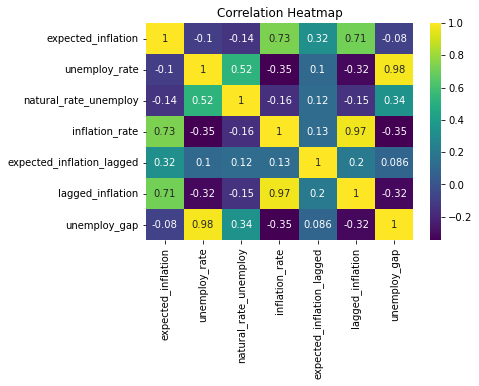

In [18]:
sns.heatmap(data.corr(), annot = True, cmap = 'viridis')
plt.title('Correlation Heatmap')

### Simple Linear Regression Model:

inflation_rate = β0 + β1*Expected Inflation + β2*unemploy_gap + β3*lagged_inflation + ε

where **inflation_rate** is the dependent variable, and **Expected Inflation**, **unemploy_gap**, and **lagged_inflation** are the independent variables. 
<br>
<br>
The coefficients β1, β2, and β3 represent the change in the **inflation_rate** associated with a one-unit increase in **Expected Inflation**, **unemploy_gap**, and **lagged_inflation**, respectively, while holding the other variables constant. 

<br>
β0 is the intercept term, which represents the expected value of the **inflation_rate** when all the independent variables are equal to zero. The error term "ε" represents the unobserved factors that affect the inflation_rate but are not accounted for by the independent variables.


In [19]:
#Simple Linear Regression
model = smf.ols('inflation_rate ~ expected_inflation + unemploy_gap + lagged_inflation', data=data).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         inflation_rate   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     713.6
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           5.26e-78
Time:                        19:37:30   Log-Likelihood:                -54.545
No. Observations:                 128   AIC:                             117.1
Df Residuals:                     124   BIC:                             128.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3964      0

In [20]:
model.conf_int()

,0,1
Intercept,-0.740430,-0.052380
expected_inflation,0.109235,0.399287
unemploy_gap,-0.097697,-0.012193
lagged_inflation,0.805759,0.932765


In [21]:
model.params

Intercept            -0.396405
expected_inflation    0.254261
unemploy_gap         -0.054945
lagged_inflation      0.869262
dtype: float64

it appears that all four variables have p-values less than 0.05, which suggests that they are all statistically significant at the 5% level. Therefore, you can conclude that all of the variables in the model are significant predictors of the inflation_rate at the 5% level.

a linear regression model is a simple but powerful tool that allows us to explore the relationships between variables and make predictions based on those relationships. By estimating the coefficients of the model, we can quantify the strength and direction of the relationships between the dependent and independent variables, and use the model to make predictions for new values of the independent variables.

However, it's important to keep in mind that linear regression has certain assumptions that must be met in order for the model to be valid. For example, the model assumes that there is a linear relationship between the independent and dependent variables, that the error term is normally distributed and has constant variance, and that there is no multicollinearity between the independent variables. If these assumptions are not met, the results of the model may be biased or misleading.

Additionally, linear regression is just one type of regression analysis, and there are many other types of models that may be more appropriate for different types of data or research questions. Therefore, it's important to consider the strengths and limitations of different types of models and choose the one that is most appropriate for the specific research question at hand.

# Conclusion

In [22]:
# Store The results from the linear regression model in this variable:
model_results = None
#This is done, so I can call the results outside the program.
"""#Note that if you call the fit_linear_regression() function multiple times, 
the model_results variable will be overwritten each time, 
so you should make sure to only call the function once and save the results
in a separate variable if you want to compare multiple models"""


# Create dropdown menu for dependent variable
dependent_var_dropdown = widgets.Dropdown(options=list(data.columns))

# Create dropdown menus for independent variables
independent_var_dropdowns = []
for col in data.columns:
    if col != dependent_var_dropdown.value:
        dropdown = widgets.Dropdown(options=[None] + list(data.columns.drop(col)))
        independent_var_dropdowns.append(dropdown)

# Create text above dropdown menus to explain variable meanings
dependent_var_text = widgets.Label(value='Select dependent variable:')
independent_var_texts = [widgets.Label(value=f'Select independent variable {i+1}:') for i in range(len(independent_var_dropdowns))]

# Define function to fit linear regression model and display results
def fit_linear_regression(dependent_var, independent_vars):
    global model_results
    formula = f'{dependent_var} ~ {" + ".join([var for var in independent_vars if var])}'
    model = smf.ols(formula=formula, data=data).fit()
    print(model.summary())
    model_results = model

# Create button to fit linear regression model
button = widgets.Button(description='Fit Linear Regression Model')

def on_button_clicked(button):
    independent_vars = [dropdown.value for dropdown in independent_var_dropdowns]
    fit_linear_regression(dependent_var_dropdown.value, independent_vars)

button.on_click(on_button_clicked)

# Display dropdown menus, text, and button
display(dependent_var_text)
display(dependent_var_dropdown)
for i in range(len(independent_var_dropdowns) - 1):
    display(independent_var_texts[i])
    display(independent_var_dropdowns[i])
display(button)

Label(value='Select dependent variable:')

Dropdown(options=('expected_inflation', 'unemploy_rate', 'natural_rate_unemploy', 'inflation_rate', 'expected_…

Label(value='Select independent variable 1:')

Dropdown(options=(None, 'expected_inflation', 'natural_rate_unemploy', 'inflation_rate', 'expected_inflation_l…

Label(value='Select independent variable 2:')

Dropdown(options=(None, 'expected_inflation', 'unemploy_rate', 'inflation_rate', 'expected_inflation_lagged', …

Label(value='Select independent variable 3:')

Dropdown(options=(None, 'expected_inflation', 'unemploy_rate', 'natural_rate_unemploy', 'expected_inflation_la…

Label(value='Select independent variable 4:')

Dropdown(options=(None, 'expected_inflation', 'unemploy_rate', 'natural_rate_unemploy', 'inflation_rate', 'lag…

Label(value='Select independent variable 5:')

Dropdown(options=(None, 'expected_inflation', 'unemploy_rate', 'natural_rate_unemploy', 'inflation_rate', 'exp…

Button(description='Fit Linear Regression Model', style=ButtonStyle())